# Method 6 

## 1: Data preperation
Extraction of normal PPG segments around a normal blood pressure measurement.

#### Importing several libraries  
These libraries are commonly used for data analysis, visualization, file handling, and signal processing tasks.

In [ ]:
# A library for data manipulation and analysis. 
# It provides data structures like DataFrames that allow to work with structured data efficiently.
import pandas as pd

# A library for numerical computations.
import numpy as np
from numpy.ma.core import zeros_like

# A plotting library that provides a wide range of functions for creating static, animated, and interactive visualizations.
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# A module that helps you find files/directories matching a specified pattern.
import glob

# A library for reading and writing Excel files in Python.
import openpyxl

# A module that provides a way to interact with the operating system. It allows to perform operations like accessing files, directories, and environment variables.
import os

# A module for manipulating dates and times.
import datetime
from datetime import datetime

# A module that provides signal processing functions for filtering, spectral analysis, interpolation, and more.
from scipy import signal
from scipy.signal import savgol_filter, argrelextrema

# A library for heart rate variability (HRV) analysis.
import heartpy as hp

# A module that provides functions for generating random numbers, selecting random elements, shuffling sequences, and more.
import random

# A class from the sklearn.model_selection module that is used for creating a cross-validation splitting strategy that takes into account grouping or clustering of data samples.
from sklearn.model_selection import GroupKFold

# A class from the sklearn.impute module that provides strategies for imputing missing values in a dataset.
from sklearn.impute import SimpleImputer

# A class from the collections module that helps you count the frequency of elements in a list or an iterable.
from collections import Counter

# Install several Python packages using the %pip install command. 
# %pip install heartpy
# %pip install matplotlib notebook
# %pip install imbalanced-learn
# %pip install --upgrade scikit-learn
# %pip install --upgrade imbalanced-learn
# %pip install scikit-learn==0.24.2
# %pip install imbalanced-learn==0.8.0

#### Upload meta-data 
The metadata obtained from Nervio contains weight, height and gender data of all patients according to their ID number. This dataset also contains a baseline time used to indicate the onset of anesthesia for each patient.

In [ ]:
# Upload the meta data excel file to a data frame
directory = "C:/Users/shaha/Desktop/Final Project-PPG/Patient_details.xlsx"
patients_meta_data = pd.read_excel(directory, engine='openpyxl')

# Change the ID column name for convenience
patients_meta_data.rename(columns={'IONM': 'patient_ID'}, inplace=True)

# Creating a new column of the base time for the indication of the start of anesthesia. 
# Based on the value of Anesthesia Induction if it exists, or alternatively the value of the first time when propofol/muscle paralyzer is given.
patients_meta_data['baseline_time'] = patients_meta_data['Anesthesia Induction'].copy()
patients_meta_data['new_column'] = np.nan
for i, booli in enumerate(patients_meta_data['Propofol: Diprivan,Diprofol \ Scholine'].notna()):
    if booli:
        val = patients_meta_data['Propofol: Diprivan,Diprofol \ Scholine'][i]
        new_val = pd.to_datetime(val).to_pydatetime()
        patients_meta_data.at[i, 'new_column'] = new_val
patients_meta_data['baseline_time'].fillna(patients_meta_data['new_column'], inplace=True)

# Fix a specific value that contains str instead of datetime
date_string = patients_meta_data['baseline_time'][59:60].values[0]
datetime_obj = datetime.strptime(date_string, "AM %I:%M %d/%m/%Y")
patients_meta_data.at[59, 'baseline_time'] = datetime_obj

# Drop the unneccesery columns of the data frame
columns_to_drop = ['new_column', 'Propofol: Diprivan,Diprofol \ Scholine', 'Anesthesia Induction']
patients_meta_data = patients_meta_data.drop(columns_to_drop, axis=1)

# Apply SimpleImputer to the Weight column that not have values for all the patients
column_to_impute = 'Weight'
impute_df = patients_meta_data[[column_to_impute]]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_column = pd.DataFrame(imp.fit_transform(impute_df), columns=[column_to_impute])
patients_meta_data[column_to_impute] = imputed_column

#### Upload the BPs data 
The Excel files of the blood pressure labels received from Nervio include two sheets for each patient. One sheet contains the invasive blood pressure measurements taken from the anesthesia system and the other sheet contains the non-invasive blood pressure measurements taken with a measuring cuff. The invasive blood pressure data is more reliable and therefore when this data is available it will be used except in cases where there is no invasive data and therefore the non-invasive data will be taken for labeling.

In [2]:
def import_data_BP(patient):
    """
    This function imports and prepares the blood pressure (BP) files for a specific patient.
    
    Parameters:
    - patient (str): The patient identifier or pattern to match the BP files.
    
    Returns:
    - df_BP_prep (pandas DataFrame): The prepared BP data for the patient.
    - type_BP (str): The type of blood pressure (either 'Invasive' or 'Non Invasive').
    """
    
    # Directory where the BP files are located
    directory = "C:/Users/shaha/Desktop/Final Project-PPG/DATA_PPG_till 250922/PPG+BP_data/"
    
    # Create a pattern to match the BP file for the specified patient
    pattern = '*' + patient 
    
    # Search for the BP file matching the pattern
    excel_file = glob.glob(directory + pattern + '.xlsx')
    
    # Specify the columns to import from the BP file
    usecols = ['Unnamed: 0', 'Unnamed: 1']
    
    # Read the Invasive BP sheet from the excel file using pandas
    df_IBP = pd.read_excel(excel_file[0], sheet_name='Invasive BP', usecols=usecols, engine='openpyxl')
    
    # Assume the type of BP is Invasive
    type_BP = 'Invasive'
    
    if len(df_IBP) > 2 : 
        # If the length of the Invasive BP DataFrame is greater than 2 (indicating it has data),
        # perform data preparation on the Invasive BP data using the Data_Preperation_BP function
        df_IBP_prep = Data_Preperation_BP(df_IBP)
        
        # Get the start of the Invasive BP 
        start_IBP = df_IBP_prep['DataTime'][2]
        
        # Return the prepared Invasive BP DataFrame and the type of BP
        return df_IBP_prep, type_BP
   
    else: 
        # If the Invasive BP DataFrame has no data, read the Non Invasive BP sheet from the excel file
        df_NIBP = pd.read_excel(excel_file[0], sheet_name='NIBPS D', usecols=usecols, engine='openpyxl')
        
        # Perform data preparation on the Non Invasive BP data using the Data_Preperation_BP function
        df_NIBP_prep = Data_Preperation_BP(df_NIBP)
        
        # Get the start of the Non Invasive BP using the start_BP function
        start_NIBP = df_NIBP_prep['DataTime'][2]
        
        # Set the type of BP as Non Invasive
        type_BP = 'Non Invasive'
        
        # Return the prepared Non Invasive BP DataFrame and the type of BP
        return df_NIBP_prep, type_BP

In [ ]:
def Data_Preperation_BP(df_BP):
    """
    This function performs data preparation on the blood pressure (BP) data frame.

    Parameters:
    - df_BP (pandas DataFrame): The BP data frame to be prepared.

    Returns:
    - df_BP (pandas DataFrame): The prepared BP data frame.
    """

    # Delete the first 2 rows from the BP data frame
    df_BP = df_BP.drop(labels=[0, 1], axis=0)

    # Fix the indexes to start from 0
    df_BP.reset_index(drop=True, inplace=True)

    # Rename the titles of the BP data frame
    df_BP.rename(columns={'Unnamed: 0': 'DataTime', 'Unnamed: 1': 'Value'}, inplace=True)

    # Separate the column 'Value' into two columns: 'SBP' and 'DBP'
    df_BP[['SBP', 'DBP']] = df_BP['Value'].str.split('/', expand=True)

    # Separate the column 'DataTime' into different columns for each time part
    df_BP['DataTime'] = pd.to_datetime(df_BP['DataTime'])

    # Check for any NaN values in 'SBP' or 'DBP' columns
    c1 = df_BP['SBP'].isna().sum()
    c2 = df_BP['DBP'].isna().sum()
    if (c1 > 0) or (c2 > 0):
        # This BP data includes NaN values. Treat this by dropping them.
        df_BP = df_BP.dropna(subset=['SBP'])
        df_BP = df_BP.dropna(subset=['DBP'])

    # Create a column for mean arterial pressure (MAP) using the formula: 1/3(SBP) + 2/3(DBP)
    df_BP['SBP'] = df_BP['SBP'].astype(int)
    df_BP['DBP'] = df_BP['DBP'].astype(int)
    df_BP['MAP'] = (1/3 * df_BP['SBP']) + (2/3 * df_BP['DBP'])

    # Reset the index of the BP data frame
    df_BP.reset_index(drop=True, inplace=True)

    # Return the prepared BP data frame
    return df_BP

#### Upload the PPG data
The Excel files of the PPG signals received from Nerbio include between a single file and several continuous files for each patient, so the file name includes the patient's ID number. Each file contains many columns extracted from the PPG sensor. The relevant columns we have passed are the PLETH column which describes the PPG wave signal itself, the time column in the jumps in which the sample was taken (every 10 milliseconds) and the Prefusion index column which indicates the correctness of the measurement, so that a measurement in which the value is above 1 is considered correct.

In [ ]:
def import_data_PPG(patient):
    """
    This function finds all the files associated with a specific patient.

    Parameters:
    - patient (str): The patient identifier or pattern to match the files.

    Returns:
    - csv_files (list): A list of file paths matching the patient identifier.
    """

    # Folder path where the files are located
    folder_path = "C:/Users/shaha/Desktop/Final Project-PPG/DATA_PPG_till 250922/"

    # Create a pattern to match the files for the specified patient
    pattern = '*' + patient

    # Search for the files matching the pattern in the folder
    csv_files = glob.glob(folder_path + pattern + '.csv')

    # Return the list of file paths
    return csv_files

In [ ]:
def FileName_and_dfPPG_and_FileNum(patient):
    """
    This function creates data frames of the patient's files and returns the number of files.

    Parameters:
    - patient (str): The patient identifier or pattern to match the files.

    Returns:
    - files (list): A list of pandas DataFrames containing the patient's files.
    - files_names (list): A list of file names corresponding to each DataFrame.
    """

    # Folder path where the files are located
    folder_path = "C:/Users/shaha/Desktop/Final Project-PPG/DATA_PPG_till 250922/"

    # Initialize empty lists for the files and file names
    files = []
    files_names = []

    # Use the import_data_PPG function to get the list of file paths
    csv_files = import_data_PPG(patient)

    # Check if any files were found
    if csv_files:
        # Iterate over each file path
        for i, csv in enumerate(csv_files):
            # Read the CSV file and create a DataFrame
            df = pd.read_csv(csv_files[i])
            files.append(df)

            # Get the file name by removing the folder path from the file path
            file_name = csv.replace("\\", "/").replace(folder_path, "")
            files_names.append(file_name)

        # Get the number of files
        num_of_files = len(files)
        print(f'Patient number: {patient}, has {num_of_files} files of PPG.')

    # Return the list of DataFrames and file names
    return files, files_names

In [ ]:
def total_time_PPG(df):
    """
    This function calculates the total time of the PPG file based on the 'TIMESTAMP_MS' column.

    Parameters:
    - df (pandas DataFrame): The PPG data frame containing the 'TIMESTAMP_MS' column.

    Returns:
    - hours (float): The total time of the PPG file in hours.
    """

    # Get the last value in the 'TIMESTAMP_MS' column (in milliseconds)
    last_value = df.iloc[-1]['TIMESTAMP_MS']

    # Convert milliseconds to seconds
    seconds = last_value / 1000

    # Convert seconds to minutes
    minutes = seconds / 60

    # Convert minutes to hours
    hours = minutes / 60

    # Return the total time in hours
    return hours

In [ ]:
# A function that concatenates all the processes into one function.

def patient_all_data(patient, files, files_names, df_BP, type_BP, len_signal, padding, patients_meta_data, all_parts_num=0, rows_parts_num=0, valid_bp_parts_num=0, parts_num=0):
    """
    This function performs various data processing steps and concatenates them into one function.

    Parameters:
    - patient (str): The patient identifier or pattern.
    - files (list): A list of pandas DataFrames representing the patient's files.
    - files_names (list): A list of file names corresponding to each DataFrame.
    - df_BP (pandas DataFrame): The blood pressure (BP) data frame.
    - type_BP (str): The type of blood pressure ('Invasive' or 'Non Invasive').
    - len_signal (float): The length of the PPG signal in seconds.
    - padding (float): The padding time in seconds.
    - patients_meta_data (pandas DataFrame): Meta data of patients.
    - all_parts_num (int, optional): The total number of parts encountered in the process.
    - rows_parts_num (int, optional): The number of parts that meet the row condition.
    - valid_bp_parts_num (int, optional): The number of parts that meet the blood pressure condition.
    - parts_num (int, optional): The number of valid segments.

    Returns:
    - df_list (list): A list of pandas DataFrames representing the merged data for each file.
    - concatenated_df (pandas DataFrame): The concatenated data frame with relevant columns.
    - total_time_file (float): The total time of the patient's files.
    - all_parts_num (int): The updated total number of parts encountered in the process.
    - rows_parts_num (int): The updated number of parts that meet the row condition.
    - valid_bp_parts_num (int): The updated number of segments that meet the blood pressure condition.
    """

    # Multiply the signal and padding lengths by 100 to account for 10 ms per row
    len_signal *= 100
    padding *= 100

    # Initialize empty lists and variables
    df_list = []
    total_time_file = 0
    all_non_invasive_BP = 0
    all_invasive_BP = 0
    # Iterate over each file DataFrame
    for i, df in enumerate(files):
        # Count the total time of the case
        total_time_file += total_time_PPG(df)

        # Get the start time of the BP measurement from the meta data
        start_time = patients_meta_data.loc[patients_meta_data['patient_ID'] == int(patient), 'baseline_time'].values[0]
        df.insert(0, 'BaseLine_Time', start_time)

        # Insert patient metadata columns into the DataFrame
        df = df.assign(Age=patients_meta_data.loc[patients_meta_data['patient_ID'] == int(patient), 'Age'].values[0],
                       Weight=patients_meta_data.loc[patients_meta_data['patient_ID'] == int(patient), 'Weight'].values[0],
                       Gender=patients_meta_data.loc[patients_meta_data['patient_ID'] == int(patient), 'Gender'].values[0])

        # Create a column 'DataTime' filled with the start time of the file
        df.insert(0, 'DataTime', start_time)

        # Fix the 'DataTime' column with the correct time calculated by 10 ms jumps
        df['DataTime'] = pd.to_timedelta(df['TIMESTAMP_MS']*1e6) + df['DataTime']

        # Create dummy columns with NaN values according to the BP columns
        df = df.assign(DataTime_BP=np.nan, SBP=np.nan, DBP=np.nan, MAP=np.nan, BP_type=np.nan)


        # Find the boundaries of the closest datetimes
        index0 = abs(df.at[0, 'DataTime'] - df_BP['DataTime']).argmin()
        index1 = abs(df.at[df.shape[0]-1, 'DataTime'] - df_BP['DataTime']).argmin()

        for row in range(index0, index1+1):
            # Find the index of the PPG DataFrame that has the closest time of BP measurement
            BP_ind = abs(df['DataTime'] - df_BP.at[row, 'DataTime']).argmin()
            
            # Insert the BP rows in the appropriate index of the PPG DataFrame
            df.at[BP_ind, 'DataTime_BP'] = df_BP.at[row, 'DataTime']
            df.at[BP_ind, 'SBP'] = df_BP.at[row, 'SBP']
            df.at[BP_ind, 'DBP'] = df_BP.at[row, 'DBP']
            df.at[BP_ind, 'MAP'] = df_BP.at[row, 'MAP']
            
            # Insert the BP type column with int values instead of str 
            df.loc[BP_ind, 'BP_type'] = {'Invasive': 1, 'Non Invasive': 0}.get(type_BP, -1)
                
        # Find and insert the value of the BP at the start time of the PPG file
        start_BP_ind = abs(start_time - df_BP['DataTime']).argmin()
        baseline_BP = df_BP.at[start_BP_ind, 'MAP']
        df.insert(0, 'BaseLine_MAP', baseline_BP)

        # Create a merged DataFrame with only the signal+padding rows parts of every BP measurement
        n = int(len_signal + (padding*2))
        has_BP_df = df[~df['DataTime_BP'].isna()]
        merged_df = pd.DataFrame()
        file_count_parts = 0

        for ind in range(len(has_BP_df)):
            index = has_BP_df.iloc[ind:ind+1].index[0]
            part_df = pd.DataFrame()
            part_df = df[:int(index+(padding)+1)][-n:]
            all_parts_num += 1
            
            # Check if every part (n rows) of the merged DataFrame is valid and meets the row condition
            cond_1 = (part_df.iloc[-1]['TIMESTAMP_MS'] - part_df.iloc[0]['TIMESTAMP_MS']) == ((n*10)-10)
            if cond_1:
                rows_parts_num += 1

            # Check if every part (n rows) of the merged DataFrame meets the blood pressure condition
            cond_2 = ((has_BP_df['SBP'] > 290) & (has_BP_df['SBP'] > 40)).sum() == 0
            if cond_1 & cond_2:
                valid_bp_parts_num += 1

            # Check if every part (n rows) of the merged DataFrame meets the perfusion index condition
            cond_3 = (part_df['PERFUSION_INDEX'] >= 1).sum() == len(part_df)
            if cond_1 & cond_2 & cond_3:
                parts_num += 1
                part_df['Part_Number'] = parts_num
                merged_df = pd.concat([merged_df, part_df])
                file_count_parts += 1

        df_list.append(merged_df)
        print(f'The {i+1} file of this patient includes {file_count_parts} valid segments of {n/100} seconds.')
    
    # Concatenate the rows of the data frames
    concatenated_df = pd.concat(df_list)

    # Drop all non-relevant columns from the concatenated data frame
    if len(concatenated_df) > 0:
        concatenated_df = concatenated_df.drop(labels=['COUNTER', 'DEVICE_ID', 'SPO2_STATUS', 'BATTERY_PCT', 'PERFUSION_INDEX'], axis=1)
    concatenated_df.reset_index(drop=True, inplace=True)

    return df_list, concatenated_df, total_time_file, all_parts_num, rows_parts_num, valid_bp_parts_num

#### Create a full data frame contains all valid PPG segments around valid blood pressure measurements

In [ ]:
def create_ID_list():
    """
    This function retrieves a list of all the unique IDs present in the 'PPG+BP_data' folder.

    Returns:
    - ID_list_unique (list): A list of unique IDs extracted from the filenames in the folder.
    """

    # Specify the folder path
    folder_path = "C:/Users/shaha/Desktop/Final Project-PPG/DATA_PPG_till 250922/PPG+BP_data/"

    # Get the list of filenames in the folder (excluding the last one)
    files = os.listdir(folder_path)[:-1]

    # Initialize an empty list to store unique IDs
    ID_list_unique = []

    # Iterate over each filename
    for file in files:
        # Extract the ID from the filename
        start = file.find("_") + 1
        ids = file[start:-5]  # Remove the file extension (.xlsx)
        ID_list_unique.append(ids)

    return ID_list_unique

In [ ]:
# Processes data for multiple patients and creates a comprehensive DataFrame (full_df) that combines the processed data for all patients. 
# It also tracks the total time of each patient's case in the case_times list.

# Calling the create_ID_list() function to obtain a list of patient IDs (patient_list).
patient_list = create_ID_list()

# Create an empty DataFrame (full_df) to store the processed data of all patients.
full_df = pd.DataFrame()

# process the data for the first patient specified as '22043146'.
patient = '22043146'

# Calls the FileName_and_dfPPG_and_FileNum() function to retrieve the files and file names for the patient.
files, files_names = FileName_and_dfPPG_and_FileNum(patient)

# Calls the import_data_BP() function to import the patient's BP data and determine the type of BP.
df_BP, type_BP = import_data_BP(patient)

# Calls the patient_all_data() function to process the patient's data and retrieve relevant information
df_list, df, total_time_file, all_parts_num, rows_parts_num, valid_bp_parts_num = patient_all_data(patient, files, files_names, df_BP, type_BP, 5, 1, patients_meta_data)

# Adds the patient ID (patient) as a column in the df DataFrame.
df['patient_ID'] = patient

# Concatenates the df DataFrame to the full_df DataFrame.
full_df = pd.concat([full_df, df])

# Appends the total time of the patient's case (total_time_file) to the case_times list.
case_times = []
case_times.append(total_time_file)

# Process the data for the remaining patients in the patient_list using a loop. 
# It performs similar steps as mentioned above, including retrieving files, importing BP data, processing patient data, adding the patient ID as a column, concatenating the processed data to full_df, and appending the total time of each patient's case to case_times.
for patient in range(1, len(patient_list)):
    files, files_names = FileName_and_dfPPG_and_FileNum(patient_list[patient])
    df_BP, type_BP = import_data_BP(patient_list[patient])
    parts_num = full_df['Part_Number'][-1:].values[0]
    df_list, concatenated_df, total_time_file, all_parts_num, rows_parts_num, valid_bp_parts_num = patient_all_data(patient_list[patient], files, files_names, df_BP, type_BP, 5, 1, patients_meta_data, all_parts_num, rows_parts_num, valid_bp_parts_num, parts_num)
    concatenated_df['patient_ID'] = patient_list[patient]
    full_df = pd.concat([full_df, concatenated_df])

    case_times.append(total_time_file)
    
# Fix the last patient import data
patient = '53403719'
directory = "C:/Users/shaha/Desktop/Final Project-PPG/DATA_PPG_till 250922/"
pattern = '*' + patient
excel_file = glob.glob(directory + pattern + '.xlsx')

# Read the Excel file for the last patient
df = pd.read_excel(excel_file[0], sheet_name='20220524T160016.406+0300_534037', engine='openpyxl')
df['patient_ID'] = patient

# Prepare the files, files_names, df_BP, and type_BP for the last patient
files = [df]
file_name = excel_file[0].replace("\\", "/").replace(directory, "")
files_names = [file_name]
df_BP, type_BP = import_data_BP(patient)

# Get the parts_num from full_df
parts_num = full_df['Part_Number'][-1:].values[0]

# Process the data for the last patient
df_list, df, total_time_file, all_parts_num, rows_parts_num, valid_bp_parts_num = patient_all_data(patient, files, files_names, df_BP, type_BP, 5, 1, patients_meta_data, all_parts_num, rows_parts_num, valid_bp_parts_num, parts_num)

# Append the total_time_file to case_times
case_times.append(total_time_file)

# Concatenate the processed data for the last patient to full_df
full_df = pd.concat([full_df, df])

# Reset the indexes
full_df.reset_index(drop=True, inplace=True)

#### Calculates and prints various statistics related to the processed data.

In [ ]:
# Display the total number of parts before any filtering.
print(f'Total segments before any filtering: {all_parts_num}')

# Display the number of segments that meet the rows filtering condition.
print(f'Rows segments: {rows_parts_num}, which are {np.round((rows_parts_num/all_parts_num)*100,2)}%')

# Display the number of segments that meet both the rows and perfusion index filtering conditions. the number of segments that meet the valid BP filtering condition.
print(f'Valid BP segments: {valid_bp_parts_num}, which are {np.round((valid_bp_parts_num/rows_parts_num)*100,2)}%')

# Display the number of segments that meet both the rows and perfusion index filtering conditions.
parts_num = full_df['Part_Number'][-1:].values[0]
print(f'Valid segments (after 2 filtering- rows & prefusion index): {parts_num}, which are {np.round((parts_num/valid_bp_parts_num)*100,2)}%')

# Display the number of valid segments that have invasive & non invasive BP reference
non_invasive_BP = full_df.loc[full_df['BP_type'] == 0, 'Part_Number'].nunique()
invasive_BP = full_df.loc[full_df['BP_type'] == 1, 'Part_Number'].nunique()
print(f'Valid segments with invasive BP reference: {invasive_BP}, and non invasive BP reference: {non_invasive_BP}')

# Display the range of the total time of the cases.
print(f'Maximum case time: {np.round(np.max(case_times),5)}, minimum case time: {np.round(np.min(case_times),5)}')
print(f'Median case time: {np.round(np.median(case_times), 3)}')

## 2: Split the data to train & test
The code performs a GroupKFold split on the df_split DataFrame to create train and test sets for a supervised learning task.

In [ ]:
# Create a copy of the full_df DataFrame
df_split = full_df.copy()

# Define the parameters to the GroupKFold split
X = df_split.drop(['patient_ID', 'MAP', 'BP_type', 'DBP', 'SBP', 'DataTime_BP', 'BaseLine_MAP'], axis=1)
Y = df_split[['MAP', 'BP_type', 'DBP', 'SBP', 'DataTime_BP', 'BaseLine_MAP']]
groups = df_split['patient_ID']

# Initialize the GroupKFold object with n_splits=5
gfk = GroupKFold(n_splits=5)

# Generate the train and test indices using the GroupKFold split
train_idx, test_idx = next(gfk.split(X, Y, groups=groups))

# Create the train and test data frames using the indices

# Select the rows from df_split based on the train indices
train = df_split.iloc[train_idx]

# Select the rows from df_split based on the test indices
test = df_split.iloc[test_idx]

# Reset the indices of train and test data frames
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Create copies of the train and test data frames
train_df = train.copy()
test_df = test.copy()

# Count the parts in the train and test data frames
parts_train = len(np.unique(train['Part_Number']))
parts_test = len(np.unique(test['Part_Number']))

# Print the total number of parts, train parts, and test parts
print(f'Total number of parts: {parts_train + parts_test}, {parts_train} train parts and {parts_test} test parts.')

In [ ]:
def count_parts(df, kind):
    """
    Count the number of parts and the distribution of BP types in the given DataFrame.
    
    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - kind (str): The kind of data or category to count parts for.
    
    Returns:
    None
    
    Prints the count of total parts, invasive BP parts, non-invasive BP parts, and parts with no BP recorded.
    """

    # Count the total number of unique segments
    total_parts = len(np.unique(df['Part_Number']))
    
    # Count the invasive & non-invasive parts in the DataFrame
    
    # Count the number of rows where 'BP_type' is 1.0 (indicating invasive BP)
    invasive_BP = (df['BP_type'] == 1.0).sum()
    
    # Count the number of rows where 'BP_type' is 0 (indicating non-invasive BP)
    no_invasive_BP = (df['BP_type'] == 0).sum()

    # Print the counts of parts for the given kind
    print(f'{kind} - total parts: {total_parts}, invasive BP: {invasive_BP}, non-invasive BP: {no_invasive_BP}')

In [ ]:
# Use the count_parts function to count the number of segments in this step
count_parts(train_df, 'train')
count_parts(test_df, 'test')

## 3: Pre-processing
Pre-processing of PPG signal segments includes smoothing the signal, finding cycles using the peak points in each cycle, two-dimensional normalization of PPG signals. Also, rejecting low-quality segments and cutting the segments so that they contain complete waves.

#### A: Noise filtering
Noise filtering by a fourth-order Savitzky–Golay filter with a window size of 19. This filter is a moving average filter to smooth the PPG signal in order to reduce noise and capture trends or patterns in the data.

In [ ]:
def Filter_Savitzky_Golay(data):
    """
    Filter the PLETH signal by segments using the Savitzky-Golay filter.

    Parameters:
    - data (DataFrame): The DataFrame containing the PLETH signal and segments numbers.

    Returns:
    None

    Modifies the input DataFrame by adding a new column 'PLETH_filtered' containing the filtered signal.
    """

    # Group the PLETH signal by segments
    grouped_df = data['PLETH'].groupby(data['Part_Number'])
    PLETH_filtered = np.array([])

    # Apply the Savitzky-Golay filter to each segment of the PLETH signal
    for part in grouped_df:
        part_filtered = savgol_filter(part[1].values, window_length=19, polyorder=4)
        PLETH_filtered = np.concatenate((PLETH_filtered.ravel(), part_filtered.ravel()))

    # Add a new column to the DataFrame with the filtered signal
    data['PLETH_filtered'] = PLETH_filtered

In [ ]:
# Apply the filter on the train & test segments
Filter_Savitzky_Golay(train_df)
Filter_Savitzky_Golay(test_df)

#### B: Trend removel
The removal of the trend line caused by the breathing activity has also been removed from the segments

In [ ]:
def Trend_Removel(data):
    """
    Apply trend removal to the PLETH signal by parts.

    Parameters:
    - data (DataFrame): The DataFrame containing the PLETH signal and part numbers.

    Returns:
    None

    Modifies the input DataFrame by updating the 'PLETH_filtered' column with the trend-removed signal.
    """

    # Group the filtered PLETH signal by part number
    grouped_df = data['PLETH_filtered'].groupby(data['Part_Number'])
    PLETH_trend_removal = np.array([])

    # Apply trend removal to each part of the filtered PLETH signal
    for part in grouped_df:
        part_detrend = signal.detrend(part[1])
        PLETH_trend_removal = np.concatenate((PLETH_trend_removal.ravel(), part_detrend.ravel()))

    # Update the 'PLETH_filtered' column with the trend-removed signal
    data['PLETH_trend_removel'] = PLETH_trend_removal

In [ ]:
# Apply the trend removel on the train & test segments
Trend_Removel(train_df)
Trend_Removel(test_df)

#### C: Cycle detection
Using the heartpy library, for each segment the cycles were defined based on finding the peak points of each cycle in the single.

In [ ]:
def get_max_peaks(data):
    """
    Extract the indices of the maximum peaks from the input data using the heartpy library.

    Parameters:
    - data (array-like): The input data for peak extraction.

    Returns:
    - max_peaks (numpy array): An array of indices representing the positions of the maximum peaks.
    """
    
    # The input data is processed using the heartpy library's `process()` function with a sampling rate of 100.0 (100 Hz).
    working_data, measures = hp.process(data, 100.0)
    
    # Extract the 'peaklist' from the 'working_data' dictionary.
    max_peaks = np.array(working_data['peaklist'])
    
    return max_peaks

In [ ]:
def get_min_peaks(data, max_peaks):
    """
    Extract the indices of the minimum peaks from the input data based on the indices of the maximum peaks.

    Parameters:
    - data (array-like): The input data for peak extraction.
    - max_peaks (array-like): An array of indices representing the positions of the maximum peaks.

    Returns:
    - min_peaks (numpy array): An array of indices representing the positions of the minimum peaks.
    """
    
    # Initialized 'min_peaks' list to store the indices of the minimum peaks.
    min_peaks = []

    # Check if the minimum value between the first maximum peak and the preceding data point is less than the first data point. 
    if np.min(data[1:max_peaks[0]]) < data[0]:
        # If true, the index of the minimum value is appended to 'min_peaks'.
        min_peaks.append(np.argmin(data[0:max_peaks[0]]))

    # Iterates over pairs of adjacent maximum peaks using a loop. 
    for peak0, peak1 in zip(max_peaks[:-1], max_peaks[1:]):
        # Find the index of the minimum value within the corresponding data range between the two maximum peaks and appends it to 'min_peaks'.
        min_peaks.append(peak0 + np.argmin(data[peak0:peak1]))
        
    # 'min_peaks' list is converted to a numpy array.
    min_peaks = np.array(min_peaks)
    
    return min_peaks

In [ ]:
def get_peaks(data):
    """
    Calculate the indices of the minimum and maximum peaks in the input data using the `get_max_peaks()` and `get_min_peaks()` functions.

    Parameters:
    - data (array-like): The input data for peak extraction.

    Returns:
    - max_peaks (numpy array): An array of indices representing the positions of the maximum peaks.
    - min_peaks (numpy array): An array of indices representing the positions of the minimum peaks.
    """
    
    # Use `get_max_peaks()` funtion to calculate the indices of the maximum peaks in the input data.
    max_peaks = get_max_peaks(data)
   
    # Use `get_min_peaks()` with the input data and the indices of the maximum peaks to calculate the indices of the corresponding minimum peaks.
    min_peaks = get_min_peaks(data, max_peaks)
    
    # Check the sizes of the `max_peaks` and `min_peaks` arrays to ensure they have the same number of elements. If the sizes are not equal, it adjusts the `max_peaks` array by removing the first element.
    if max_peaks.size > min_peaks.size:
        max_peaks = max_peaks[1:]
    elif max_peaks.size < min_peaks.size:
        max_peaks = max_peaks[1:]

    return max_peaks, min_peaks

#### D: Disqualification of segments
Artifacts were filtered from the training data set according to two requirements defined by learning the best parameters, so that only high-quality signals were retained while leaving enough data for training. The segments were rejected by defining the coefficient of variation for time (X) and amplitude (Y).

In [ ]:
def Conditions_PPG(data, max_peaks, min_peaks, amp_cv=4, time_cv=12):
    """
    Apply filtering conditions to identify "good" segments of the signal based on amplitude and time criteria.

    Parameters:
    - data (array-like): The input PPG signal data.
    - max_peaks (numpy array): An array of indices representing the positions of the maximum peaks.
    - min_peaks (numpy array): An array of indices representing the positions of the minimum peaks.
    - amp_std (float): The threshold value for the amplitude coefficient of variation. Default is 4.
    - time_std (float): The threshold value for the time coefficient of variation. Default is 12.

    Returns:
    - amp_standart_score (float): The normalized amplitude standard score.
    - time_standart_score (float): The normalized time standard score.
    - is_good_part (bool): Indicates whether the part of the signal satisfies the filtering conditions.
    """
    
    # Calculate the time differences between consecutive minimum and maximum peaks in the PPG signal.
    time_min = min_peaks[1:] - min_peaks[:-1]
    time_max = max_peaks[1:] - max_peaks[:-1]

    # Calculate the mean time difference and calculate the amplitude coefficient of variation using the mean and standard deviation.
    mean_time = (time_min + time_max) / 2
    time_cv_score = mean_time.mean() / mean_time.std()

    # Calculate the amplitude differences between corresponding maximum and minimum peaks and calculate the time coefficient of variation using the mean and standard deviation.
    amp = data[max_peaks] - data[min_peaks]
    amp_cv_score = amp.mean() / amp.std()

    # Checks if the normalized amplitude coefficient of variation is greater than amp_std and the normalized time standard score is greater than time_std.
    if (amp_cv_score > amp_cv) and (time_cv_score > time_cv):
        # If both conditions are satisfied, the segment of the signal is considered "good".
        return amp_cv_score, time_cv_score, True
    
    else:
        # If the conditions are not met,the segment of the signal is considered " not good".
        return amp_cv_score, time_cv_score, False

#### E: 2-dimensional normalization
For the signal segments that passed the above conditions, normalization was performed in width and amplitude.

In [ ]:
def normalize_data(data, max_peaks, min_peaks):
    """
    Normalize the PPG signal data between peaks by performing linear normalization on the corresponding data points 
    within each peak window.

    Parameters:
    - data (array-like): The input PPG signal data.
    - max_peaks (numpy array): An array of indices representing the positions of the maximum peaks.
    - min_peaks (numpy array): An array of indices representing the positions of the minimum peaks.

    Returns:
    - norm_data (numpy array): The normalized amplitude (y) coordinates between peaks.
    - norm_time (numpy array): The normalized time (x) coordinates between peaks.
    - all_peaks (numpy array): An array of indices representing the positions of all peaks.
    - max_peaks (numpy array): The original positions of the maximum peaks.
    - min_peaks (numpy array): The original positions of the minimum peaks.
    """

    # Initializes arrays for storing the normalized time and amplitude values.
    norm_data = np.zeros_like(data)
    norm_time = norm_data.copy()
    
    # Concatenates the positions of maximum and minimum peaks into a single array and sorts them in ascending order.
    all_peaks = np.sort(np.concatenate([max_peaks, min_peaks], axis=0))

    # Iterates over eacSh pair of consecutive peaks and performs linear normalization on the corresponding data points 
    # within the window.
    for i, (peak0, peak1) in enumerate(zip(all_peaks[:-1], all_peaks[1:])):
        window = data[peak0:peak1].copy()
        if peak0 == peak1:
            window = np.append(window, peak0)
        window -= window.min()
        window /= window.max()
        norm_data[peak0:peak1] = window
        norm_time[peak0:peak1] = np.linspace(0.5 * i, 0.5 * (i + 1), window.size + 1)[1:]
    
    return norm_data, norm_time, all_peaks, max_peaks, min_peaks

#### F: Cutting into whole cycles
Cutting of the normal and normalized segments was performed so that each segment contains only complete cycles. That is, each section now contains a sequence of complete cycles only, from the first high point to the last high point.

In [ ]:
def cutting_into_whole_cycles(data, time, max_peaks, min_peaks):
    """
    Cuts the data into whole cycles by trimming the time and amplitude arrays to exclude values outside the range of the concatenated peaks.

    Parameters:
    - data (numpy array): The amplitude (y) coordinates.
    - time (numpy array): The time (x) coordinates.
    - all_peaks (numpy array): An array of indices representing the positions of all peaks.
    - max_peaks (numpy array): The original positions of the maximum peaks.
    - min_peaks (numpy array): The original positions of the minimum peaks.

    Returns:
    - time (numpy array): The trimmed time (x) coordinates.
    - data (numpy array): The trimmed amplitude (y) coordinates.
    - fix_min_peaks (numpy array): The adjusted positions of the fixed minimum peaks.
    - fix_max_peaks (numpy array): The adjusted positions of the fixed maximum peaks.
    """

    # Trim the normalized time and amplitude arrays to exclude any values outside the range of the concatenated peaks.
    all_peaks = np.sort(np.concatenate([max_peaks, min_peaks], axis=0))
    data = data[all_peaks[0]:all_peaks[-1]]
    time = time[all_peaks[0]:all_peaks[-1]]
    time[0] = 0
    
    # Adjusts the positions of the normalized maximum and minimum peaks to match the trimmed arrays.
    fix_max_peaks = max_peaks - all_peaks[0]
    fix_min_peaks = min_peaks - all_peaks[0]

    # If the last position of the normalized maximum peaks is greater than the last position of the normalized minimum peaks, it decrements the last position of the normalized maximum peaks by 1.
    if fix_max_peaks[-1] > fix_min_peaks[-1]:
        fix_max_peaks[-1] -= 1
        
    # If the last position of the normalized maximum peaks is less than the last position of the normalized minimum peaks, it decrements the last position of the normalized minimum peaks by 1.
    elif fix_max_peaks[-1] < fix_min_peaks[-1]:
        fix_min_peaks[-1] -= 1

    return time, data, fix_min_peaks, fix_max_peaks

#### All the pre-processing 
Display all the pre-process steps on the data (train & test) 

In [ ]:
def norm_df_with_peaks(data, max_peaks, min_peaks):
    """
    Creates a normalized data frame with the peaks by applying normalization and cutting into whole cycles.

    Parameters:
    - data (numpy array): The original PPG signal data.
    - max_peaks (numpy array): The positions of the maximum peaks.
    - min_peaks (numpy array): The positions of the minimum peaks.

    Returns:
    - norm_part_df (pandas DataFrame): The normalized data frame with the peaks.
    """

    # Call the normalize_data function to normalize the data based on the maximum and minimum peaks.
    norm_data, norm_time, all_peaks, max_peaks, min_peaks = normalize_data(data, max_peaks, min_peaks)
    
    # Call the cutting_into_whole_cycles function to trim the normalized data to include only whole cycles.
    norm_time, norm_data, norm_min_peaks, norm_max_peaks = cutting_into_whole_cycles(norm_data, norm_time, all_peaks, max_peaks, min_peaks)
    
    # Create an empty DataFrame to store the normalized data.
    norm_part_df = pd.DataFrame()
    
    # Add columns for normalized time and data.
    norm_part_df['norm_time(X)'] = norm_time
    norm_part_df['norm_data(y)'] = norm_data
    
    # Assign 'Min' and 'Max' labels to the corresponding peaks.
    norm_part_df.loc[norm_min_peaks, 'peak'] = 'Min'
    norm_part_df.loc[norm_max_peaks, 'peak'] = 'Max'
    
    return norm_part_df

In [ ]:
def df_with_peaks(data, max_peaks, min_peaks):
    """
    Creates the original data frame with the peaks by extracting the peaks from the original data.

    Parameters:
    - data (pandas DataFrame): The original PPG data frame.
    - max_peaks (numpy array): The positions of the maximum peaks.
    - min_peaks (numpy array): The positions of the minimum peaks.

    Returns:
    - new_part_df (pandas DataFrame): The original data frame with the peaks.
    """

    # Create a copy of the second part of the original data frame to store the new data frame with the peaks.
    new_part_df = data[1].copy()

    # Reset the index of the new data frame to ensure sequential index values.
    new_part_df.reset_index(drop=True, inplace=True)

    # Concatenate the positions of the maximum and minimum peaks into a single array and sort them in ascending order.
    all_peaks = np.sort(np.concatenate([max_peaks, min_peaks], axis=0))

    # Assign 'Min' and 'Max' labels to the rows in the new data frame corresponding to the positions of the minimum and maximum peaks, respectively.
    new_part_df.loc[min_peaks, 'peak'] = 'Min'
    new_part_df.loc[max_peaks, 'peak'] = 'Max'
    
    # Extracts the data between the first and last peak positions to include only the relevant data within the peaks.
    new_part_df = new_part_df[all_peaks[0]:all_peaks[-1]]

    # Calculate the number of cycles in the segment by 2 and subtracting 1 (since the first peak is not considered a complete cycle).
    cycle_nums = (len(all_peaks) / 2) - 1
    
    # Add a new column 'Num_of_Cycles_in_part' to the new data frame, indicating the number of cycles in each part.
    new_part_df['Num_of_Cycles_in_part'] = cycle_nums

    return new_part_df

In [ ]:
def pre_processing1(df):
    """
    Performs the first stage of pre-processing on the given PPG data frame.
    Its include peak extraction, condition evaluation, and creating the normalized and processed data frames.
    
    Parameters:
    - df (pandas DataFrame): The input PPG data frame.

    Returns:
    - norm_df (pandas DataFrame): The normalized data frame with the peaks.
    - processed_df (pandas DataFrame): The processed data frame with the peaks and additional information.
    - parts_with_peaks (int): The number of parts that contain peaks.
    - parts_after_conditions (int): The number of parts that satisfy the conditions for further processing.
    """

    # Group the data frame by the 'Part_Number' column
    grouped_df = df.groupby(df['Part_Number'])

    # Initialize variables to track part numbers, parts with peaks, and parts after applying conditions
    part_num = 0
    parts_with_peaks = 0
    parts_after_conditions = 0

    # Create empty data frames for the normalized data and processed data
    norm_df = pd.DataFrame()
    processed_df = pd.DataFrame()
    processed_df['Num_of_Cycles_in_part'] = np.nan

    # Iterate over each segment in the grouped data frame
    for part in grouped_df:
        # Extract the PPG signal for the segment
        data = (part[1]['PLETH_trend_removel'].values).copy()
        
        try:
            # Attempt to find the max and min peaks using the 'get_peaks' function
            max_peaks, min_peaks = get_peaks(data)
            parts_with_peaks += 1
        except:
            pass
        else:
            # Evaluate the conditions on the PPG data using the 'Conditions_PPG' function
            amp_coefficient_variation_score, time_coefficient_variation_score, booli = Conditions_PPG(data, max_peaks, min_peaks)
            
            if booli:
                parts_after_conditions += 1
                # Create the normalized data frame with the peaks
                norm_part_df = norm_df_with_peaks(data, max_peaks, min_peaks)
                part_num += 1
                norm_part_df['Part_Number'] = part_num
                norm_df = pd.concat([norm_df, norm_part_df])

                # Create the original data frame with the peaks
                new_part_df = df_with_peaks(part, max_peaks, min_peaks)
                new_part_df['Part_Number'] = part_num
                processed_df = pd.concat([processed_df, new_part_df])

    # Reset the index of the normalized data frame and processed data frame
    norm_df.reset_index(drop=True, inplace=True)
    processed_df.reset_index(drop=True, inplace=True)

    return norm_df, processed_df, parts_with_peaks, parts_after_conditions

In [ ]:
# Apply the first pre-processing function on the train & test data
norm_train_df1, train_df1, parts_with_peaks_train, parts_after_conditions_train = pre_proccesing1(train_df)
norm_test_df1, test_df1, parts_with_peaks_test, parts_after_conditions_test = pre_proccesing1(test_df)

In [ ]:
# Find the maximum value that represent the number of segments in each data frame
train_parts = train_df['Part_Number'].values[-1]
test_parts = test_df['Part_Number'].values[-1]

# Print the percentage of train segments with peaks and passing the conditions
print(f'Train parts that found peaks for them: {parts_with_peaks_train}, which are: {np.round((parts_with_peaks_train/train_parts)*100, 2)}%')
print(f'Train parts that passed the conditions: {parts_after_conditions_train}, which are: {np.round((parts_after_conditions_train/parts_with_peaks_train)*100, 2)}%')
print('\n')

# Print the percentage of test segments with peaks and passing the conditions
print(f'Test parts that found peaks for them: {parts_with_peaks_test}, which are: {np.round((parts_with_peaks_test/test_parts)*100, 2)}%')
print(f'Test parts that passed the conditions: {parts_after_conditions_test}, which are: {np.round((parts_after_conditions_test/parts_with_peaks_test)*100, 2)}%')

In [ ]:
def pre_processing2(norm_df, df):
    """
    Pre-processes the normalized and original data frames by matching the MAP values to the corresponding segments.

    Parameters:
        norm_df (DataFrame): Normalized data frame.
        df (DataFrame): Original data frame.

    Returns:
        Tuple: A tuple containing the pre-processed normalized data frame, pre-processed original data frame, and the number of parts with blood pressure (MAP) values.
    """

    # Group the original data frame by segments.
    grouped_df = df.groupby('Part_Number')

    # Initialize variables.
    parts_with_BP = 0
    processed_df_list = []
    processed_norm_df_list = []

    # Iterate over each segment in the original data frame.
    for part_number, data in grouped_df:
        
        # Check if there is only one non-null MAP value in the segment. If there is label of BP, save this segment.
        if data['MAP'].notna().sum() == 1:
            parts_with_BP += 1  
            data['Part_Number'] = parts_with_BP  
            processed_df_list.append(data)  

            # Find the matching part in the normalized data frame.
            data_norm = norm_df[norm_df['Part_Number'] == part_number].copy()
            data_norm['Part_Number'] = parts_with_BP 
            
            # Extract the MAP value from the original data frame.
            MAP_val = data['MAP'].dropna().values[0]  
            data_norm['MAP'] = MAP_val  
            processed_norm_df_list.append(data_norm)  

    # Concatenate the processed normalized segmwnts and processed original segments into separate data frames
    processed_norm_df = pd.concat(processed_norm_df_list).reset_index(drop=True)
    processed_df = pd.concat(processed_df_list).reset_index(drop=True)

    return processed_norm_df, processed_df, parts_with_BP

In [ ]:
# Apply the second pre-processing function on the train & test data
norm_train_df2, train_df2, parts_with_BP_train = pre_proccesing2(norm_train_df1, train_df1)
norm_test_df2, test_df2, parts_with_BP_test = pre_proccesing2(norm_test_df1, test_df1)

In [ ]:
# Print the percentage of train segments that passed all the pre-processing
print(f'Train parts with BP: {parts_with_BP_train}, which are: {np.round((parts_with_BP_train/parts_after_conditions_train)*100,2)}')

# Print the percentage of test segments that passed all the pre-processing
print(f'Test parts with BP: {parts_with_BP_test}, which are: {np.round((parts_with_BP_test/parts_after_conditions_test)*100,2)}')

## 4: Feature extraction and selection
Extraction and selection of waveform characteristics from the processed PPG signal segments. Also performing EDA for the purposes of visualization and analysis of the selected characteristics.

#### Importing several libraries

In [9]:
# A module from matplotlib allows for custom formatting of tick labels on plots
import matplotlib.ticker as ticker

# A library to perform 1-dimensional interpolation of data.
from scipy.interpolate import interp1d

# Generating random numbers or selecting random elements.
import random

#### Features extraction
3 different features were extracted, including information about the PPG waveform and information about the patients.

In [21]:
# Set all the df for this level
train_df = train_df2.copy()
test_df = test_df2.copy()
norm_train_df = norm_train_df2.copy()
norm_test_df = norm_test_df2.copy()

# Define X columns in the data frames for use in the features 
train_df['X'] =  train_df.index
test_df['X'] = test_df.index

In [22]:
def Define_Cycle(data):
    """
    This function takes a DataFrame containing PPG data with identified peaks and defines the cycles in the segment based on the last peak (min or max).
    
    Parameters:
        data (DataFrame): A DataFrame containing PPG data with a 'peak' column indicating the type of peak (min or max).
        
    Returns:
        start_peak (bool): A boolean value indicating whether the starting peak is a minimum (True) or maximum (False).
        cycles_data (DataFrame): A subset of the input data containing only the cycles in the segment.
    """
    
    # Find all the indices of the peaks in the segment
    peaks = data[data['peak'].notna()].copy()
    
    # Determine the starting peak based on the last peak type
    if peaks.iloc[-1]['peak'] == 'Min':
        start_ind = peaks[peaks['peak'] == 'Min'].index[0]
        start_peak = True
    else:
        start_ind = peaks[peaks['peak'] == 'Max'].index[0]
        start_peak = False
        
    # Return only the cycles in the segment starting from the identified peak
    cycles_data = data.loc[start_ind:]
    
    return start_peak, cycles_data

#### Group feature 1: Amplitde area
The first group of features is the area under the curve. This area reflects the changes in blood vessel tone and is therefore an important features for predicting blood pressure.

In [ ]:
def Calc_Area_Feature(data, df, x_name, y_name):
    """
    This function calculates the area under the curve of a segment, which represents the pulse rising time.
    
    Parameters:
        data (DataFrame): A DataFrame containing PPG data with a 'peak' column indicating the type of peak (min or max).
        df (DataFrame): The original DataFrame containing PPG data with corresponding x and y values.
        x_name (str): The column name in df representing the x-axis values.
        y_name (str): The column name in df representing the y-axis values.
        
    Returns:
        area_cycles_arr (ndarray): An array containing the calculated areas for each cycle in the segment.
    """
    
    # Find all the indices of the peaks in the part
    peak_index = data[data['peak'].notna()].index
    area_cycles_arr = np.array([])
    
    # Calculate the area of each cycle and store the values in an array
    for i in range(2, len(peak_index), 2):
        cycle = df[peak_index[i-2]:peak_index[i]+1]
        dx = np.gradient(cycle[x_name])
        area_cycle = np.sum(dx * cycle[y_name])
        area_cycles_arr = np.append(area_cycles_arr, area_cycle.round(3))
    
    return area_cycles_arr

In [ ]:
def Group_Feature_1_AREA(part_norm_df, norm_df, n_part, features):
    """
    This function creates the group feature 1: Area for a specific segment and adds it to the features DataFrame.

    Parameters:
        part_norm_df (DataFrame): The normalized DataFrame for the specific segment.
        norm_df (DataFrame): The normalized DataFrame for the entire dataset.
        n_part (int): The part number.
        features (DataFrame): The DataFrame to which the feature columns will be added.
    """
    
    area_norm = Calc_Area_Feature(part_norm_df, norm_df, 'norm_time(X)', 'norm_data(y)')

    # Average of all the cycles area in each part
    features.loc[n_part-1, 'F1_Area_Avg_Norm'] = np.mean(area_norm).round(6)

#### Group feature 2:  Width Amplitude
The second set of features is the amplitude width so set the amplitude width at 25%. They indicate the resistance of system tools.

In [ ]:
def Width(norm_df, peaks_index, i, high):
    """
    This function calculates the width of the amplitude according to a given parameter "high".
    
    Parameters:
        norm_df (DataFrame): A DataFrame containing normalized PPG data with 'norm_data(y)' and 'norm_time(X)' columns.
        peaks_index (ndarray): An array of indices representing the peaks in the PPG data.
        i (int): The index of the current peak.
        high (float): The value of the Y-coordinate to find the width at.
        
    Returns:
        width (float): The calculated width of the amplitude.
    """
    
    # Find the parts from peak to peak
    c1 = norm_df[peaks_index[i]:peaks_index[i+1]+1]
    c2 = norm_df[peaks_index[i+1]:peaks_index[i+2]+1]
    
    # Create interpolation functions
    f_c1 = interp1d(c1['norm_data(y)'], c1['norm_time(X)'])
    f_c2 = interp1d(c2['norm_data(y)'], c2['norm_time(X)'])

    # Find x-coordinate where y = high
    width = f_c2(high) - f_c1(high)
    
    return width.round(4)

In [25]:
def Width_feature(part, norm_df):
    """
    This function finds the width at 25% for each cycle in a part and creates arrays for each width.
    
    Parameters:
        part (DataFrame): A DataFrame representing a part of the PPG data.
        norm_df (DataFrame): A DataFrame containing normalized PPG data with 'norm_data(y)' and 'norm_time(X)' columns.
        
    Returns:
        width_25_cycles_arr (ndarray): An array of widths at 25% of the amplitude for each cycle in the segment.
    """
    
    # Find the index of the peaks in the segment
    peaks_index = part[part['peak'].notna()].index
    width_25_cycles_arr = np.array([])

    # For every cycle, find the width at 25%, 50%, and 75% of the amplitude
    for i in range(0, len(peaks_index)-2, 2):
        width_25 = Width(norm_df, peaks_index, i, 0.25)

        width_25_cycles_arr = np.append(width_25_cycles_arr, width_25)
        
    return width_25_cycles_arr

In [ ]:
def Avg_Width_Part(width_25_cycles):
    """
    This function calculates the average width of the cycles in a segment based on the 25% width.

    Parameters:
        width_25_cycles (ndarray): Array containing the widths at 25% for each cycle.

    Returns:
        float: A float containing the average widths at 25%.
    """
    
    avg_width_25 = np.mean(width_25_cycles).round(6)

    return avg_width_25

In [ ]:
def Group_Feature_2_WIDTH(part_norm_df, norm_df, n_part, features):
    """
    Calculates width-related group features for each segment based on the normalized data.

    Parameters:
        part_norm_df (DataFrame): Normalized DataFrame for the current segment.
        norm_df (DataFrame): Overall normalized DataFrame.
        n_part (int): Part number.
        features (DataFrame): DataFrame to store the calculated features.

    Returns:
        A list of the segment number that width feature doesnt find for them

    """
    
    no_width_part = []
    # Attempt to calculate the width features
    try:
        width_25_cycles = Width_feature(part_norm_df, norm_df)
    except:
        # Set average and standard deviation values to NaN if width cycles are not found
        avg_width_25 = np.full(3, np.nan)
        no_width_part.append(n_part)
    else:
        # Calculate average and standard deviation of width cycles
        avg_width_25 = Avg_Width_Part(width_25_cycles)
     
    features.loc[n_part-1, f'F2_Avg_Width_25_Norm'] = avg_width_25
    
    return no_width_part

#### Group feature 3: ROR 
The third set of features is pulse rise time (ROR). These features represent the systolic time and indicate changes in blood pressure, meaning contraction of the heart chambers respectively.

In [ ]:
def calculate_ror(data, x_name, start_peak):
    """
    This function calculates the Rate of Rise (ROR) for the cycles in each segment.

    Parameters:
        data (DataFrame): A DataFrame representing a part of the PPG data.
        x_name (str): The name of the column representing the x-coordinate (time or normalized time).
        start_peak (bool): A boolean value indicating if the first peak is a minimum (True) or maximum (False).

    Returns:
        ror_arr (ndarray): An array of ROR values for each cycle in the segment.
    """
    
    # Select only the rows that are peaks
    peaks_index = data[data['peak'].notna()].copy().index
    ror_arr = np.array([])
    
    if start_peak:
        # If the last peak is a 'Min', calculate ROR starting from the first minimum peak
        for i in range(0, len(peaks_index)-2, 2): 
            # Calculate ROR
            max_idx = peaks_index[i+1]
            first_min_idx = peaks_index[i]
            ror_val = data.loc[max_idx, x_name] - data.loc[first_min_idx, x_name]

    else:
        # If the last peak is a 'Max', calculate ROR starting from the first maximum peak
        for i in range(0, len(peaks_index)-2, 2):            
            # Calculate ROR
            sec_max_idx = peaks_index[i+2]
            min_idx = peaks_index[i+1]
            ror_val = data.loc[sec_max_idx, x_name] - data.loc[min_idx, x_name]
            
            ror_arr = np.append(ror_arr, ror_val)
            rof_arr = np.append(rof_arr, rof_val)

    return ror_arr

In [ ]:
def Group_Feature_3_ROR(part_norm_df, n_part, features, start_peak_norm):
    """
    Calculates the group features related to ROR (Rate of Rise) for each segment.

    Args:
        part_norm_df (DataFrame): DataFrame containing the normalized data for the current segment.
        n_part (int): Integer representing the part number.
        features (DataFrame): DataFrame to store the calculated features.
        start_peak_norm (str): Start peak type for normalized data ('Min' or 'Max').
    """
    
    ror_arr_norm = calculate_ror(part_norm_df, 'norm_time(X)', start_peak_norm)
    
    # Average of all ROR in each segment
    features.loc[n_part-1, 'F3_Avg_ROR_Norm'] = np.mean(ror_arr_norm).round(6)

#### Labels 
4 different labels were defined, sistolic blood pressure value (SBP), diastolic blood pressure value (DBP), difference of change, and the ratio of change in MAP value based on its value at baseline.

In [ ]:
def Create_Label_Columns(part_df, n_part, features):
    """
    This function creates the label columns for a specific segment and adds them to the features DataFrame.

    Parameters:
        part_df (DataFrame): The DataFrame containing the data for the specific segment.
        n_part (int): The part number.
        features (DataFrame): The DataFrame to which the label columns will be added.
    """
    
    # Create a feature column with the baseline BP 
    baseline_Map_val = part_df[part_df['BaseLine_MAP'].notna()]['BaseLine_MAP'].values[0]
    features.loc[n_part-1, 'BaseLine_MAP'] = baseline_Map_val

    # LABEL 1: Create a column of the BP for each part
    MAP_val = part_df[part_df['MAP'].notna()]['MAP'].values[0]
    features.loc[n_part-1, 'MAP'] = MAP_val

    # LABEL 2: Create another label column of the change in the BP (MAP)
    change_MAP_val = MAP_val - baseline_Map_val
    features.loc[n_part-1, 'L2_Change_MAP'] = change_MAP_val

    # LABEL 4: Create the label column of the SBP
    SBP_val = part_df[part_df['SBP'].notna()]['SBP'].values[0]
    features.loc[n_part-1, 'L3_SBP'] = SBP_val

    # LABEL 5: Create the label column of the DBP
    DBP_val = part_df[part_df['DBP'].notna()]['DBP'].values[0]
    features.loc[n_part-1, 'L4_DBP'] = DBP_val

#### Feature selection
In this method we use all the features that extracted.

In [ ]:
def Create_Features_DF(norm_df, df, parts_num):
    """
    Creates a DataFrame of features for each segment of the patient data.

    Args:
        norm_df (DataFrame): DataFrame containing the normalized patient data.
        df (DataFrame): DataFrame containing the original patient data.
        parts_num (int): Number of parts in the patient data.

    Returns:
        features (DataFrame): DataFrame containing the extracted features for each segment.
    """
    
    # Save the segment numbers that doesnt found for them the width feature
    no_width_parts = []

    # Create new DataFrame for the features
    features = pd.DataFrame()

    # Create columns that count the segment number
    features['Part'] = range(1, parts_num)

    # Split the df by segment groups, both df (original & normalized) have the same number of cycles in each segment
    grouped_norm_df = norm_df.groupby(norm_df['Part_Number'])

    for part in grouped_norm_df:
        n_part = part[0]
        part_df_full = df[df['Part_Number'] == part[0]]
        part_norm_df_full = part[1]

        # Fix the segment with only the cycles
        start_peak, part_df = Define_Cycle(part_df_full)
        start_peak_norm, part_norm_df = Define_Cycle(part_norm_df_full)

        # Create a column with the number of cycles for each part
        features.loc[n_part-1, 'Cycles'] = (len(part_norm_df[part_norm_df['peak'].notna()]) - 1) / 2

        # Create ID column
        features.loc[n_part-1, 'ID'] = part_df['patient_ID'].unique()[0]

        # Create type BP column
        features.loc[n_part-1, 'BP_type'] = part_df['BP_type'][part_df['BP_type'].notna()].values[0]

        # Create all the label columns
        Create_Label_Columns(part_df, n_part, features)

        # GROUP FEATURES 1: AREA
        Group_Feature_1_AREA(part_norm_df, norm_df, n_part, features)

        # GROUP FEATURES 2: Width amplitude (only for the normalized data) in 25%, 50%, 75%
        no_width_parts.extend(Group_Feature_2_WIDTH(part_norm_df, norm_df, n_part, features))

        # GROUP FEATURES 3: ROR & ROF
        Group_Feature_3_ROR_ROF(part_norm_df, n_part, features, start_peak_norm)

    return features, no_width_parts

In [64]:
# Find the number of segments in each data sets
n_parts_train = train_df['Part_Number'].max() + 1
n_parts_test = test_df['Part_Number'].max() + 1

# Apply the Create_Features_DF function on the train & test data sets
features_train, no_width_parts_train = Create_Features_DF(train_norm_df, train_df, n_parts_train)
features_test, no_width_parts_test = Create_Features_DF(test_norm, test_df, n_parts_test)

ERROR: 0 Parts doesnt have width feature!
ERROR: 0 Parts doesnt have width feature!


In [65]:
def drop_parts_without_width_feature(no_width_parts, df):
    """
    Drops segments without a width feature from a DataFrame and returns a modified DataFrame with updated segment numbers.

    Args:
        no_width_parts (list): List of part numbers without a width feature.
        df (pandas.DataFrame): Input DataFrame containing the data.

    Returns:
        pandas.DataFrame: Modified DataFrame with dropped parts and updated part numbers.
    """
    if no_width_parts:
        new_df = df.drop(no_width_parts[0] - 1).copy()
        new_df.reset_index(drop=True, inplace=True)
        new_df['Part'] = df.index + 1
        return new_df
    else:
        return df

In [71]:
# Apply the drop_parts_without_width_feature function to drop segments if they dont have width feature
features_train_df = drop_parts_without_width_feature(no_width_parts_train, features_train)
features_test_df = drop_parts_without_width_feature(no_width_parts_test, features_test)

# EDA
A visual look at the data of the various characteristics and labels that were extracted.

####  Number of cycles in each part

In [72]:
def Cycles_Bar_Plot(df):
    """
    Plot a bar chart of the number of cycles in the dataset.

    Args:
        df (pandas.DataFrame): Input DataFrame containing the data.
    """
    features_by_cycle = df.groupby('Cycles')
    cycle_series = features_by_cycle['Cycles'].unique().tolist()
    cycle_labels = [age[0] for age in cycle_series]

    plt.figure(figsize=(7, 4))
    plt.bar(cycle_labels, features_by_cycle['Cycles'].count(), color='maroon')
    plt.xlabel("Cycles")
    plt.ylabel("Count segments")
    plt.title('Number of Cycles')
    plt.show()

C:\Aanaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


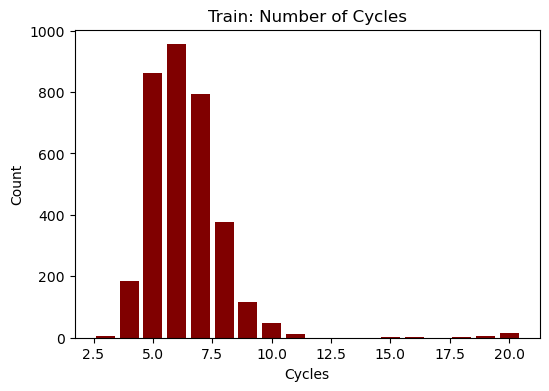

In [73]:
# Plot the cycles bar plot with the train & test data
Cycles_Bar_Plot(features_train_df)

In [ ]:
# Get unique cycles numbers in the training dataset
unique_cycles = features_train_df['Cycles'].unique()
unique_parts_df = pd.DataFrame([])

# Select one example for each unique cycles number
for unique in unique_cycles:
    unique_cycle = features_train_df[features_train_df['Cycles'] == unique]
    unique_part = unique_cycle.groupby(unique_cycle['Part'])
    for part in unique_part:
        part_df = part[1]
        unique_parts_df = pd.concat([unique_parts_df, part_df])
        break

# Plot and display the waveform data for each example
for ind in unique_parts_df.index:
    unique_parts_num = unique_parts_df['Part'][ind]
    unique_part = train_df[train_df['Part_Number'] == unique_parts_num]
    unique_wave = unique_part['PLETH_trend_removel']
    cycles_part = unique_part['Num_of_Cycles_in_part'].unique()[0]

    plt.title(f'Segment with {cycles_part} cycles')
    plt.xlabel('number of samples')
    plt.ylabel('Amplitude')
    plt.plot(unique_wave.values)
    plt.show()

#### Number of segments to every patient

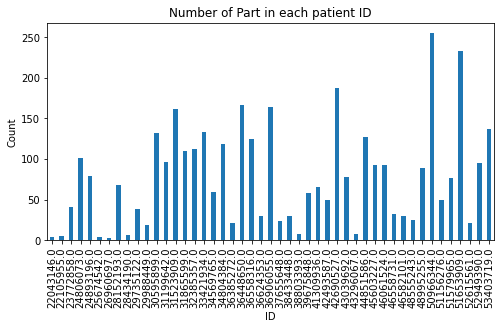

In [236]:
features_by_ID = features_train_df.groupby('ID')
id_series = features_by_ID['ID'].unique().tolist()
id_unique = [age[0] for age in id_series]
id_labels = range(1,len(id_unique)+1)

plt.figure(figsize=(7, 4))
plt.bar(id_labels, features_by_ID['ID'].count())
plt.xlabel("Patient")
plt.ylabel("Count segments")
plt.title('Number of segments for each patient')
plt.show()

#### Statistics on all the features

In [ ]:
# Initialize empty arrays to store the statistical measures for each column
count_feature = mean_feature = std_feature = min_feature = val_25_prec_feature = val_50_prec_feature = val_75_prec_feature = max_feature = feature_name = np.array([])

# Iterate over each column in the features_train_df data frame
for column in features_train_df.columns:
    # Store the column name in the feature_name array
    feature_name = np.append(feature_name, column)
    
    # Calculate and store the statistical measures for the current column using the describe() function
    describe_col = features_train_df[column].describe()
    count_feature = np.append(count_feature, describe_col[0])
    mean_feature = np.append(mean_feature, describe_col[1])
    std_feature = np.append(std_feature, describe_col[2])
    min_feature = np.append(min_feature, describe_col[3])
    val_25_prec_feature = np.append(val_25_prec_feature, describe_col[4])
    val_50_prec_feature = np.append(val_50_prec_feature, describe_col[5])
    val_75_prec_feature = np.append(val_75_prec_feature, describe_col[6])
    max_feature = np.append(max_feature, describe_col[7])

# Create the features_statistic data frame and populate it with the collected statistical measures
features_statistic = pd.DataFrame()
features_statistic['feature_name'] = feature_name
features_statistic['count'] = count_feature
features_statistic['mean'] = mean_feature
features_statistic['std'] = std_feature
features_statistic['min'] = min_feature
features_statistic['25%'] = val_25_prec_feature
features_statistic['50%'] = val_50_prec_feature
features_statistic['75%'] = val_75_prec_feature
features_statistic['max'] = max_feature

# Return the features_statistic data frame
features_statistic

#### Number of Nan values in every feature

In [238]:
# Count the number of NaN values in each column in the train data sets
nan_counts = features_train_df.isnull().sum()
print(f'The number of NaN values in each column is:\n{nan_counts[nan_counts > 0]}')

,feature_name,count,mean,std,min,25%,50%,75%,max
0,Part,3659.0,1830,1056.41,1,915.5,1830,2744.5,3659
1,Cycles,3659.0,6.44179,1.90988,3,5,6,7,20
2,ID,3659.0,4.01128e+07,8.74888e+06,2.20431e+07,3.23854e+07,3.84334e+07,4.89953e+07,5.34037e+07
3,Time_Delta_BP,3659.0,0 days 01:52:17.217819,0 days 01:09:26.772101,0 days 00:01:00,0 days 00:57:00,0 days 01:43:00,0 days 02:35:00,0 days 05:17:00
4,BaseLine_MAP,3659.0,89.9244,36.8161,38.3333,63,81,109.333,195.667
...,...,...,...,...,...,...,...,...,...
131,F6_STT_(-5),3455.0,0.000539015,0.000247373,0.000289494,0.000421927,0.000480298,0.000574981,0.00714012
132,F6_Avg_STT_Last_5_Norm,3659.0,0.483569,0.0168366,-0.510335,0.48142,0.483361,0.485641,0.504481
133,F6_Avg_STT_Last_5,3659.0,0.000541151,0.000242028,-0.008268,0.00044,0.000497,0.000578,0.005414
134,F6_Std_STT_Last_5_Norm,3659.0,0.00390002,0.00191525,0.00042,0.002818,0.003443,0.0043485,0.021536


#### Correlation Matrix

In [145]:
def Corr_Matrix(X):
    """
    Create a correlation matrix for the given DataFrame.

    Args:
        X (pandas.DataFrame): Input DataFrame.
    """
    # Normalize the features in the DataFrame
    X0 = ((X - X.mean(axis=0)) / np.linalg.norm(X - X.mean(axis=0), axis=0)).values
    norm_features_df = pd.DataFrame(X0, columns=X.columns)

    # Create the correlation matrix
    C = X0.T @ X0

    # Plot the correlation matrix
    plt.figure(figsize=(10, 10))
    plt.title('Correlation Matrix')
    plt.imshow(C, cmap='bwr')
    plt.colorbar()

In [146]:
# Create a correlation matrix of only the features in the features_train_df
X = features_train_df.drop(['Part', 'ID', 'MAP', 'L2_Change_MAP', 'L3_SBP', 'L4_DBP'], axis=1)
Corr_Matrix(X)

The number of nan values in each column is:
Series([], dtype: int64)
The number of nan values in each column is:
Series([], dtype: int64)


#### Boxplot to the distribution of each feature

In [245]:
# Plot boxplots for each feature
for column in features_train_df.columns:
    plt.boxplot(features_train_df[column])
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.title(f'Boxplot - {column}')
    plt.show()

#### Number of outliers by extreme value analysis

In [250]:
# Find outliers by extreme value analysis
def extreme_values_analysis(df):
    numeric_columns = df.select_dtypes(include=np.number)
    threshold = 3
    extreme_values_count = ((numeric_columns-numeric_columns.mean())/numeric_columns.std() > threshold).sum()
    print(f'Outliers by extreme values count per column:\n{extreme_values_count}')

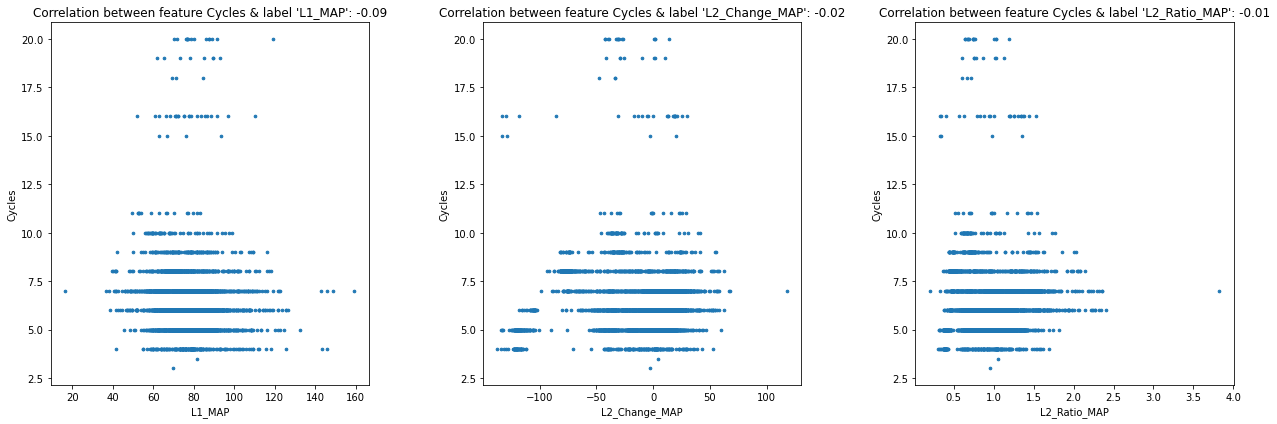

TypeError: reduction operation 'corr' not allowed for this dtype

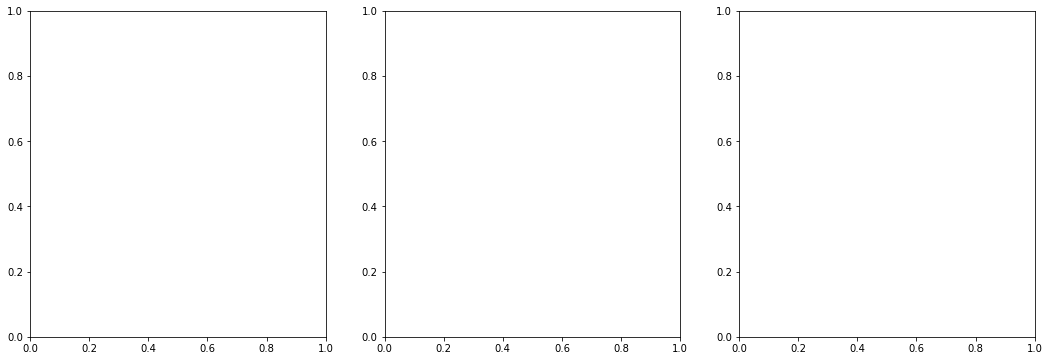

In [252]:
extreme_values_analysis(features_train_df)

# Corrections that arose from the EDA 

#### Drop the segments with less then 12 cycles
The amount of cycles that make up each segment was investigated and it was found that there are segments with an unreasonable amount of cycles that create a poor quality PPG signal. It was defined that a segment with more than 12 cycles is an abnormal signal and therefore it was removed from the data set.

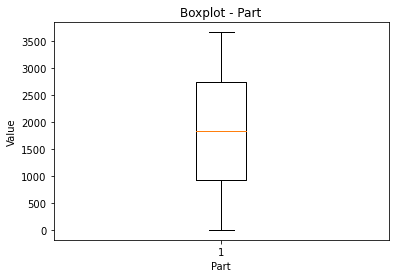

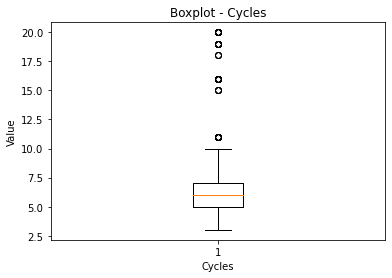

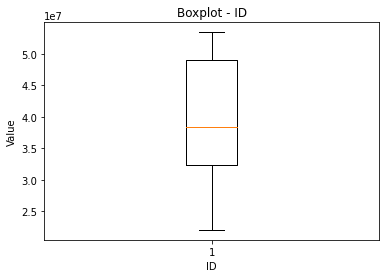

KeyError: 'Time_Delta_BP'

In [253]:
def drop_parts_with_less_than_12_cycles(df, kind):
    """
    Drops all the segments from the DataFrame that have more than 12 cycles.

    Parameters:
        df (DataFrame): The input DataFrame containing the segments and cycles information.
        kind (str): The variable specifying the data type or kind of the DataFrame.

    Returns:
        DataFrame: The modified DataFrame after dropping the segments.
    """
    parts_before = df['Part'].values[-1]

    # Filter out the segments with more than 12 cycles.
    df = df[df['Cycles'] < 12]

    # Reset the index and update the segment numbers.
    df.reset_index(drop=True, inplace=True)
    df['Part'] = df.index + 1
    
    # Print the number of segments that drop in this process.
    parts_less_then_12_cycles = df['Part'].values[-1]
    print(f'{kind} segments with less then 12 cycles: {parts_less_then_12_cycles}, which are: {np.round((parts_less_then_12_cycles/parts_before)*100,2)}%')
    
    return df, parts_before

In [258]:
# Apply the drop_parts_with_less_then_12_parts function on the train & test datasets. 
features_train_df, parts_before_train = drop_parts_with_less_than_12_cycles(features_train_df, 'Train')
features_test_df, parts_before_test = drop_parts_with_less_than_12_cycles(features_test_df, 'Test')

Outliers by extreme values count per column:
Part                       0
Cycles                    53
ID                         0
Time_Delta_BP              0
BaseLine_MAP               0
                          ..
F6_STT_(-5)               52
F6_Avg_STT_Last_5_Norm     0
F6_Avg_STT_Last_5         26
F6_Std_STT_Last_5_Norm    82
F6_Std_STT_Last_5         53
Length: 136, dtype: int64


## 5: Predictive model
Creating a predictive model using a grid search method (grid search)

#### Importing several libraries

In [ ]:
# This module provides various functions related to time, including measuring time intervals, delaying program execution, and working with timestamps.
import time

# Imports the SVR (Support Vector Regression) and SVC (Support Vector Classification) classes from the sklearn.svm module.
from sklearn.svm import SVR, SVC

# PolynomialFeatures is a class in scikit-learn (sklearn) that is used for feature engineering in machine learning.
# StandardScaler is class in the sklearn.preprocessing module that is used for standardizing features.
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# GridSearchCV is a class in scikit-learn (sklearn) that is used for hyperparameter tuning.
# GroupShuffleSplit is another class in the sklearn.model_selection module that is used for splitting data into train and test sets while preserving group structures.
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit

# PCA is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space while preserving the most important information in the data.
from sklearn.decomposition import PCA

# The IsolationForest class in scikit-learn provides methods for fitting Isolation Forest models to data and predicting the anomaly scores for new data points.
from sklearn.ensemble import IsolationForest

# r2_score is a metric used to evaluate the performance of regression models.
from sklearn.metrics import r2_score

# The `FunctionSampler` class in imbalanced-learn is a transformer that applies a given function to the input data. 
from imblearn import FunctionSampler

# In scikit-learn, a pipeline is a sequence of data processing steps combined into a single object
from imblearn.pipeline import Pipeline as Pipeline

# A is a library that provides utilities for saving and loading Python objects, particularly large numerical arrays, efficiently.
from joblib import dump, load

# A class that represents a decision tree model for regression tasks.
from sklearn.tree import DecisionTreeRegressor

#### Split the data sets to X & Y & subjects

In [ ]:
def split_X_Y_Subjects(df):
    """
    Split the input DataFrame into separate data for subjects, predictors (X), and multiple outcomes (Y).

    Parameters:
        df (DataFrame): Input DataFrame containing the data.

    Returns:
        subjects (DataFrame): DataFrame containing the subject IDs.
        Y (DataFrame): DataFrame containing multiple outcome variables (MAP, L2_Change_MAP, L3_SBP, L4_DBP).
        X (DataFrame): DataFrame containing predictor variables after removing outcome and irrelevant columns.
        Y2 (array): Array containing the values of the L2_Change_MAP outcome variable.
        Y3 (array): Array containing the values of the L3_SBP outcome variable.
        Y4 (array): Array containing the values of the L4_DBP outcome variable.
        Y1_cat (array): Array containing categorized values of the MAP outcome variable (Critical_MAP_Category).
    """

    # Separate subject IDs
    subjects = df[['ID']]

    # Separate the multiple outcome variables (Y)
    Y = df[['MAP', 'L2_Change_MAP', 'L3_SBP', 'L4_DBP']]

    # Remove the outcome and irrelevant columns to get predictors (X)
    X = df.drop(['MAP', 'L2_Change_MAP', 'L3_SBP', 'L4_DBP', 'Part', 'ID', 'BP_type'], axis=1)

    # Flatten the outcome arrays (Y1, Y2, Y3, Y4, Y5) for later processing
    Y1 = Y[['MAP']].values.ravel()
    Y2 = Y[['L2_Change_MAP']].values.ravel()
    Y3 = Y[['L3_SBP']].values.ravel()
    Y4 = Y[['L4_DBP']].values.ravel()

    # Convert the L1_MAP outcome variable to categories (Critical_MAP_Category) based on certain thresholds
    # A value <= 70 is categorized as 0, between 70 and 80 as 0.5, and above 80 as 1.
    Critical_MAP_Category = [0 if (val <= 70) else 0.5 if (val > 70 and val <= 80) else 1 for val in Y1]
    Y1_cat = np.array(Critical_MAP_Category)

    return subjects, Y, X, Y2, Y3, Y4, Y1_cat

In [ ]:
# Split the train df to X & Y
subjects_train, Y_train, X_train, Y2_train, Y3_train, Y4_train = split_X_Y_Subjects(features_train_df)

# Split the test df to X & Y
subjects_test, Y_test, X_test, Y2_test, Y3_test, Y4_test = split_X_Y_Subjects(features_test_df)

#### Pipeline & GridSearchCV 
Grid search that incorporates cross-validation against 10 data sets, each consisting of 80% training and 20% test. This division was carried out using the Group Shuffle Split method which produces a number of predetermined random splits, where each of the splits contains a portion of the predetermined subgroups. In this case, the split was defined according to patient ID and labeling category so that in each group the percentage of different labeling was distributed similarly. In this way, the training and test data sets contain segments from different patients so that the model avoids overfitting.

#### Decision tree model

In [ ]:
# Creating the Pipeline
regressor_pipe = Pipeline([('Emputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
                           ('estimator', DecisionTreeRegressor())])

# Defining the Parameter Grid to be explored during the grid search
param_grid = [{'estimator__max_depth': [None, 2, 5, 10, 20, 50, 100],
               'estimator__min_samples_split': [2, 3, 5, 10],
               'estimator__min_samples_leaf': [1, 2, 4, 8, 15]}]

#### Perform grid search, model fitting, and evaluation using cross-validation

In [ ]:
def fit_grid(X_train, X_test, y_train, y_test, subjects, pipe, param_grid, title, test_size=0.15, n_splits=10, scoring="r2"):
    """
    Perform grid search, model fitting, and evaluation using cross-validation.

    Parameters:
        X_train (array-like): The training feature matrix.
        X_test (array-like): The testing feature matrix.
        y_train (array-like): The training target variable.
        y_test (array-like): The testing target variable.
        subjects (array-like): The array containing subject IDs for grouping during cross-validation.
        pipe (Pipeline): The sklearn pipeline containing the model to be optimized.
        param_grid (dict or list of dicts): The parameter grid to be explored during grid search.
        title (str): The title used for saving the results and plots.
        test_size (float, optional): The proportion of test data during cross-validation split. Default is 0.15.
        n_splits (int, optional): The number of cross-validation splits. Default is 10.
        scoring (str, optional): The scoring method used for model evaluation. Default is "r2".

    Returns:
        grid (GridSearchCV): The fitted GridSearchCV object.
        gridFrame (DataFrame): The DataFrame containing the results of the grid search.
    """
    
    # Drop the baseline from the features to the model
    X_train_no_baseline = X_train.drop(['BaseLine_MAP'], axis=1)
    X_test_no_baseline = X_test.drop(['BaseLine_MAP'], axis=1)
    
    start_time = time.time()

    # Split the train data into multiple splits with 20% test and 80% train based on the subject IDs
    cv_splitter = GroupShuffleSplit(test_size=test_size, n_splits=n_splits)
    split = cv_splitter.split(X_train_no_baseline, groups=subjects)
    
    # Perform grid search with cross-validation
    grid = GridSearchCV(pipe, param_grid, cv=split, return_train_score=True, scoring=scoring, n_jobs=-1)
    grid.fit(X_train_no_baseline, y_train)
    
    # Save the best model from the grid search
    filename = os.path.join('Results', title+'_grid_model.sav')
    dump(grid.best_estimator_, filename)

    # Print the best parameters found during the grid search
    print(grid.best_params_)
    
    # Store the results of the grid search in a DataFrame
    gridFrame = pd.DataFrame(grid.cv_results_)

    # Save the grid search results to a CSV file
    filename = os.path.join('Results', title+'_Table_Results.csv')
    gridFrame.to_csv(filename)

    # Calculate the valid ranges of numbers to compute the score
    # based on the title of the outcome variable (e.g., MAP, SBP, DBP)
    if (title == 'SBP') or (title == 'DBP') or (title == 'MAP_ThresHold'): 
        min_val_train = min_val_test = 10
        max_val_train = max_val_test = 290

    elif title == 'Change_MAP': 
        min_val_train = 10 - X_train['BaseLine_MAP'] 
        max_val_train = 290 - X_train['BaseLine_MAP'] 
        min_val_test = 10 - X_test['BaseLine_MAP']
        max_val_test = 290 - X_test['BaseLine_MAP']
        
    elif title == 'Ratio_MAP': 
        min_val_train = 10 / X_train['BaseLine_MAP']
        max_val_train = 290 / X_train['BaseLine_MAP']
        min_val_test = 10 / X_test['BaseLine_MAP']
        max_val_test = 290 / X_test['BaseLine_MAP']
    
     # Plot the predicted and true values for train and test datasets
    plt.figure(figsize=(10,8))
    
    plt.subplot(211)
    y_hat_train = grid.predict(X_train_no_baseline)
    ind_train = (y_hat_train > min_val_train) & (y_hat_train < max_val_train)
    
    plt.plot(y_train, label='y_train_true')
    plt.plot(y_hat_train, label='y_train_pred')
    if scoring == "r2":
        plt.title(f'Train: {title} r2 scoring {r2_score(y_train[ind_train], y_hat_train[ind_train]):.3f}')
    elif scoring == "f1":
        score_f1_train = f1_score(y_train[ind_train], y_hat_train[ind_train], average= 'weighted')
        plt.title(f'Train: {title} f1 scoring {score_f1_train:.3f}')
    plt.legend(loc='upper right')
    
    
    plt.subplot(212)
    y_hat_test = grid.predict(X_test_no_baseline)
    ind_test = np.where((y_hat_test > min_val_test) & (y_hat_test < max_val_test))

    plt.plot(y_test, label='y_test_true')
    plt.plot(y_hat_test, label='y_test_pred')
    if scoring == "r2":
        plt.title(f'Test: {title} r2 scoring {r2_score(y_test[ind_test], y_hat_test[ind_test]):.3f}')
    elif scoring == "f1":
        score_f1_test = f1_score(y_test[ind_test], y_hat_test[ind_test], average= 'weighted')
        plt.title(f'Test: {title} f1 scoring {score_f1_test:.3f}')
    plt.legend(loc='upper right')
    
    # Save the plot
    filename = os.path.join('Results', title)
    plt.savefig(filename)

    end_time = time.time()
    print(f'Execute time {end_time-start_time:.0f} sec')

    return grid, gridFrame

#### Runnig the Decision tree predictive model on all the different labels

In [ ]:
# Regression Decision tree model predict Change_MAP
regressor_grid_2, regressor_gridFrame_2 = fit_grid(X_train, X_test, Y2_train, Y2_test, subjects_train,
                                                   regressor_pipe, param_grid, 'Change_MAP')

In [ ]:
# Regression Decision tree model predict SBP
regressor_grid_2, regressor_gridFrame_2 = fit_grid(X_train, X_test, Y3_train, Y3_test, subjects_train,
                                                   regressor_pipe, param_grid, 'SBP')

In [ ]:
# Regression Decision tree model predict DBP
regressor_grid_2, regressor_gridFrame_2 = fit_grid(X_train, X_test, Y4_train, Y4_test, subjects_train,
                                                   regressor_pipe, param_grid, 'DBP')

#### R2 evaluation on DMAP predict
Evaluation indices were considered based on the r2 index which measures the sum of the squared model error to a large number of squared naive model error

In [ ]:
# Load the saved regression model from the specified file
file_name = r'Results\Change_MAP_grid_model.sav'
loaded_model2 = load(file_name)
  
# Drop the baseline from the features to the model
X_train_no_baseline = X_train.drop(['BaseLine_MAP'], axis=1)
X_test_no_baseline = X_test.drop(['BaseLine_MAP'], axis=1)

# Predict the target variable (Y2) for the training and test data using the loaded model
y2_hat_train = loaded_model2.predict(X_train_no_baseline)
y2_hat_test = loaded_model2.predict(X_test_no_baseline)

# R2 calculation for the training data
# Add the predicted values to the subjects_train DataFrame
subjects_train['y2_hat_train'] = y2_hat_train

# Calculate the average predicted value for each ID group in the training data
average_bp_train = subjects_train.groupby('ID')['y2_hat_train'].mean()

# Map the 'ID'-wise average predictions to the respective rows in subjects_train DataFrame
subjects_train['Average_BP_by_ID'] = subjects_train['ID'].map(average_bp_train)

# Extract the actual target variable values (Y2_train) and the predicted values (y2_hat_train) from the DataFrame
d_m_train = subjects_train['Average_BP_by_ID'].values
d_hat_train = subjects_train['y2_hat_train'].values
d_train = Y2_train

# Calculate two alternative versions of R2 (R-squared) metrics for the training data
R2_2_train = 1-(np.sum((d_train-d_hat_train)**2) / np.sum((d_train-d_m_train)**2))
R2_3_train = 1-(np.sum((d_train-d_hat_train)**2) / np.sum(d_train**2))

# Print the original R2 score and the two alternative R2 scores for the training data
print(f'Train: original R2: {r2_score(Y2_train, y2_hat_train)}, our R2 version 2: {R2_2_train}, our R2 version 3: {R2_3_train}')


# R2 calculation for the test data
# Add the predicted values to the subjects_test DataFrame
subjects_test['y2_hat_test'] = y2_hat_test

# Calculate the average predicted value for each ID group in the test data
average_bp_test = subjects_test.groupby('ID')['y2_hat_test'].mean()

# Map the 'ID'-wise average predictions to the respective rows in subjects_test DataFrame
subjects_test['Average_BP_by_ID'] = subjects_test['ID'].map(average_bp_test)

# Extract the actual target variable values (Y2_test) and the predicted values (y2_hat_test) from the DataFrame
d_m_test = subjects_test['Average_BP_by_ID'].values
d_hat_test = subjects_test['y2_hat_test'].values
d_test = Y2_test

# Calculate two alternative versions of R2 (R-squared) metrics for the test data
R2_2_test = 1-(np.sum((d_test-d_hat_test)**2) / np.sum((d_test-d_m_test)**2))
R2_3_test = 1-(np.sum((d_test-d_hat_test)**2) / np.sum(d_test**2))

# Print the original R2 score and the two alternative R2 scores for the test data
print(f'Test: original R2: {r2_score(Y2_test, y2_hat_test)}, our R2 version 2: {R2_2_test}, our R2 version 3: {R2_3_test}')